In [367]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb
from graphs import *

api = wandb.Api()

In [368]:
project_path = "Fairness-wiki"
runs = api.runs(project_path)

N = 9
iterations = 1000
utility = lambda x: 1 / (1 + x)
metrics = [f"val/perplexity_{i}" for i in range(N)]
metrics.append("val/perplexity_mean")

In [369]:
run_by_trust = {}

for run in runs:
    group = run.group
    if group not in run_by_trust:
        run_by_trust[group] = []
    run_by_trust[group].append(run)

In [370]:
metrics_by_trust = {}

for trust, runs in run_by_trust.items():
    metrics_by_trust[trust] = {}
    for metric in metrics:
        metrics_by_trust[trust][metric] = np.empty(shape=(len(runs), iterations))
    for idx, run in enumerate(runs):
        data = run.history(samples=iterations, keys=metrics)
        for metric in metrics:
            metrics_by_trust[trust][metric][idx, :] = data[metric].to_numpy()

In [371]:
last_pp = {}

for trust in metrics_by_trust.keys():
    last_pp[trust] = {}
    for metric in metrics:
        last_pp[trust][metric] = np.mean(metrics_by_trust[trust][metric][:, -250:-200], axis=1)
        last_pp[trust][f"{metric}_std"] = np.mean(metrics_by_trust[trust][metric][:, -250:-200], axis=1)

In [372]:
def average(row):
    for col, val in row.items():
        row[col] = val.mean()
        
    return row

def var(row):
    for col, val in row.items():
        row[col] = np.sqrt(val.var())
        
    return row

In [373]:
df = pd.DataFrame(last_pp)
gains = pd.DataFrame()
for col in df.columns:
    if col != "local":
        gains[f"Gain {col}"] = utility(df[col]) - utility(df["local"])

gains[gains.index.str.contains("std")] = gains[gains.index.str.contains("std")].apply(var, axis=1)
gains[~gains.index.str.contains("std")] = gains[~gains.index.str.contains("std")].apply(average, axis=1)
gains

,Gain fed-avg,Gain val-sim,Gain val-sim-w-penalizer,Gain oracle-w-penalizer,Gain oracle
val/perplexity_0,-0.00052,0.001105,0.000929,0.00089,0.00134
val/perplexity_0_std,0.000067,0.000156,0.000282,0.000254,0.000058
val/perplexity_1,-0.001206,0.00041,-0.000622,0.000255,0.001182
val/perplexity_1_std,0.000055,0.000339,0.0018,0.000308,0.000054
val/perplexity_2,-0.000481,0.001034,-0.000797,0.000838,0.001251
val/perplexity_2_std,0.000079,0.000284,0.002633,0.000413,0.000065
val/perplexity_3,-0.000232,0.001142,0.000638,0.000613,0.00153
val/perplexity_3_std,0.000133,0.000275,0.001216,0.000449,0.000084
val/perplexity_4,-0.001016,0.000854,-0.000774,-0.00063,0.001444
val/perplexity_4_std,0.000134,0.000247,0.001927,0.000857,0.000124


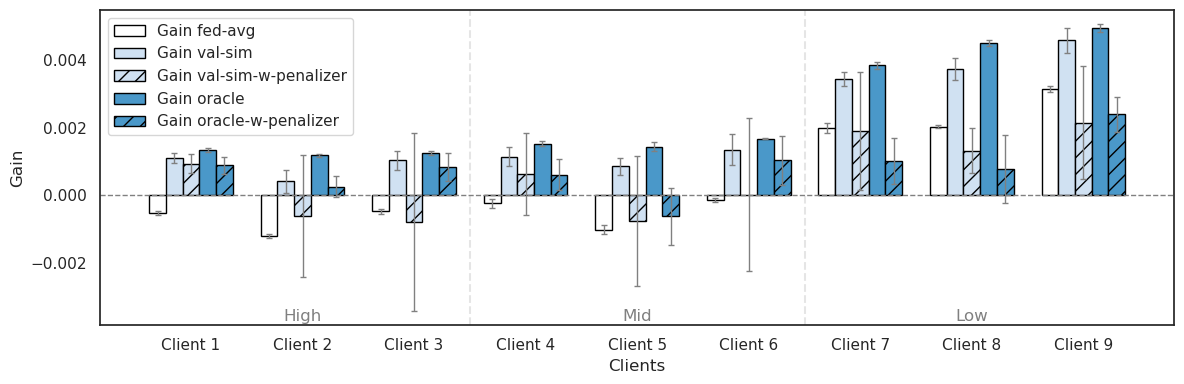

In [454]:
df_new = gains.iloc[:-2]

# Create a bar plot similar to the provided image
labels_new = [f"Client {i+1}" for i  in range(len(df_new[df_new.index.str.contains("std")].index))]


var_fed_avg_new = df_new[df_new.index.str.contains("std")]['Gain fed-avg'].values
var_val_sim_new = df_new[df_new.index.str.contains("std")]['Gain val-sim'].values
var_val_sim_w_penalizer_new = df_new[df_new.index.str.contains("std")]['Gain val-sim-w-penalizer'].values
var_oracle_w_penalizer_new = df_new[df_new.index.str.contains("std")]['Gain oracle-w-penalizer'].values
var_oracle_new = df_new[df_new.index.str.contains("std")]['Gain oracle'].values

gain_fed_avg_new = df_new[~df_new.index.str.contains("std")]['Gain fed-avg'].values
gain_val_sim_new = df_new[~df_new.index.str.contains("std")]['Gain val-sim'].values
gain_val_sim_w_penalizer_new = df_new[~df_new.index.str.contains("std")]['Gain val-sim-w-penalizer'].values
gain_oracle_w_penalizer_new = df_new[~df_new.index.str.contains("std")]['Gain oracle-w-penalizer'].values
gain_oracle_new = df_new[~df_new.index.str.contains("std")]['Gain oracle'].values

# Create a bar plot
x_new = np.arange(len(labels_new))  # the label locations
width_new = 0.15  # the width of the bars

colors = [
    "white",
    plt.cm.Blues(0.2),
    plt.cm.Blues(0.2),
    plt.cm.Blues(0.6),
    plt.cm.Blues(0.6),
]

sns.set(style="white")


fig, ax = plt.subplots(figsize=(12, 4))

plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
rects1_new = ax.bar(x_new - 2*width_new, gain_fed_avg_new, width_new, label='Gain fed-avg', color=colors[0], edgecolor='black', yerr=var_fed_avg_new, capsize=2, error_kw={'elinewidth':1, 'ecolor':'grey'})
rects2_new = ax.bar(x_new - width_new, gain_val_sim_new, width_new, label='Gain val-sim', color=colors[1], edgecolor='black', yerr=var_val_sim_new, capsize=2, error_kw={'elinewidth':1, 'ecolor':'grey'})
rects3_new = ax.bar(x_new, gain_val_sim_w_penalizer_new, width_new, label='Gain val-sim-w-penalizer', color=colors[2], edgecolor='black', hatch="//", yerr=var_val_sim_w_penalizer_new, capsize=2, error_kw={'elinewidth':1, 'ecolor':'grey'})
rects4_new = ax.bar(x_new + width_new, gain_oracle_new, width_new, label='Gain oracle', color=colors[3], edgecolor='black', yerr=var_oracle_new, capsize=2, error_kw={'elinewidth':1, 'ecolor':'grey'})
rects5_new = ax.bar(x_new + 2*width_new, gain_oracle_w_penalizer_new, width_new, label='Gain oracle-w-penalizer', color=colors[4], edgecolor='black', hatch="//", yerr=var_oracle_w_penalizer_new, capsize=2, error_kw={'elinewidth':1, 'ecolor':'grey'})


for i in [2.5, 5.5]:
    plt.axvline(x=i, color='grey', linestyle='--', alpha=0.2)

plt.text(1, max(gain_oracle_new) * -0.75, 'High', horizontalalignment='center', fontsize=12, color='grey')
plt.text(4, max(gain_oracle_new) * -0.75, 'Mid', horizontalalignment='center', fontsize=12, color='grey')
plt.text(7, max(gain_oracle_new) * -0.75, 'Low', horizontalalignment='center', fontsize=12, color='grey')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Clients')
ax.set_ylabel('Gain')
ax.set_xticks(x_new)
ax.set_xticklabels(labels_new)
ax.legend()

fig.tight_layout()
plt.savefig("img/llm_ft_bars.png")

plt.show()


In [375]:
samples_size = np.array([500000, 500000, 500000, 250000, 250000, 250000, 50000, 50000, 50000])

W = np.zeros((N, N))
for idx1 in range(N):
    for idx2 in range(N):
        if (idx1 % 3) == (idx2 % 3):
            W[idx1, idx2] = 1.
        else:
            W[idx1, idx2] = 0.

W /= (N // 3)
W *= samples_size
W /= W.sum(axis=1)
print(f"W: \n{W}")
C = (np.abs(W.T) - np.abs(W)).sum(axis=1)
print(f"Contribution vector: \n{C}")

W: 
[[0.625  0.     0.     0.3125 0.     0.     0.0625 0.     0.    ]
 [0.     0.625  0.     0.     0.3125 0.     0.     0.0625 0.    ]
 [0.     0.     0.625  0.     0.     0.3125 0.     0.     0.0625]
 [0.625  0.     0.     0.3125 0.     0.     0.0625 0.     0.    ]
 [0.     0.625  0.     0.     0.3125 0.     0.     0.0625 0.    ]
 [0.     0.     0.625  0.     0.     0.3125 0.     0.     0.0625]
 [0.625  0.     0.     0.3125 0.     0.     0.0625 0.     0.    ]
 [0.     0.625  0.     0.     0.3125 0.     0.     0.0625 0.    ]
 [0.     0.     0.625  0.     0.     0.3125 0.     0.     0.0625]]
Contribution vector: 
[ 0.875   0.875   0.875  -0.0625 -0.0625 -0.0625 -0.8125 -0.8125 -0.8125]


In [462]:
C_vec = -C
C_vec -= np.min(C_vec)
C_vec /= np.max(C_vec)
print(f"C_vec: \n{C_vec}")


def compute_prob(to_test, idx):
    probs = np.zeros_like(to_test)

    for i, contr in enumerate(to_test):
        C = (np.abs(W.T) - np.abs(W)).sum(axis=1)
        C[idx] = contr
        C_vec = -C
        C_vec -= np.min(C_vec)
        C_vec /= np.max(C_vec)
        C_sort = np.concatenate([np.expand_dims(C_vec, axis=0), np.expand_dims(samples_size, axis=0)], axis=0)
    
        unique_elements, inverse_indices = np.unique(C_sort.T, return_inverse=True, axis=0)
        unique_elements = unique_elements.T
    
        unique_elements[1, :] /= unique_elements[1, :].sum()
        unique_elements[1, 1:] = unique_elements[1, :].cumsum(axis=0)[:-1]
        unique_elements[1, 0] = 0.
        unique_elements[1, :] *= unique_elements[0, :]
        prob = unique_elements[:, inverse_indices][1, :]
        probs[i] = prob[idx].item()
        
    return probs

C_vec: 
[1.31581988e-16 0.00000000e+00 1.31581988e-16 5.55555556e-01
 5.55555556e-01 5.55555556e-01 1.00000000e+00 1.00000000e+00
 1.00000000e+00]


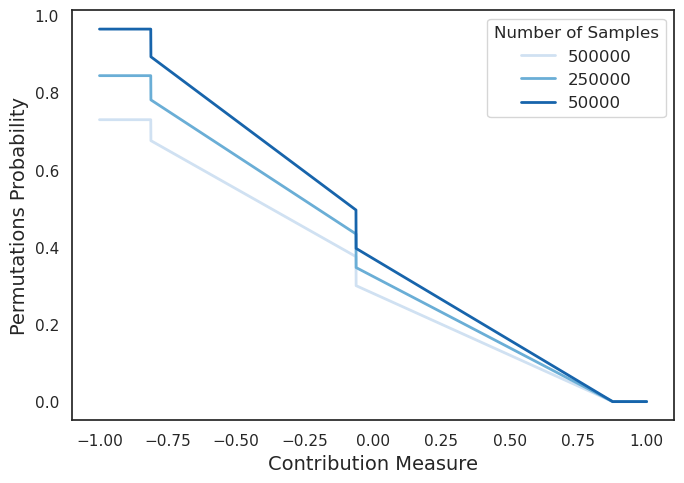

In [465]:
from matplotlib.colors import ListedColormap

contributions = np.linspace(-1, 1, 10000)
sns.set(style="white")
plt.figure(figsize=(7, 5))

colors = ListedColormap(plt.cm.Blues(np.linspace(0.2, 0.8, 3)))

for j in range(0, N, 3):
    probabilities = compute_prob(contributions, j)
    plt.plot(contributions, probabilities, label={0: 500000, 3: 250000, 6: 50000}[j], color=colors(j//3), linewidth=2)
 
plt.yticks(np.arange(0., 1.1, 0.2))

plt.xlabel('Contribution Measure', fontsize=14)
plt.ylabel('Permutations Probability', fontsize=14)
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Number of Samples', fontsize=12)
plt.tight_layout()

plt.savefig("img/contr_vs_prob.png", bbox_inches='tight')

plt.show()

In [467]:
def compute_prob_without(to_test, idx):
    probs = np.zeros_like(to_test)

    for i, contr in enumerate(to_test):
        C = (np.abs(W.T) - np.abs(W)).sum(axis=1)
        C[idx] = contr
        C_vec = -C
        C_vec -= np.min(C_vec)
        C_vec /= np.max(C_vec)
        prob = C_vec / samples_size
        print(prob)
        prob -= prob.min()
        prob /= prob.max()
        probs[i] = prob[idx].item()
        
    return probs

[2.00000000e-06 0.00000000e+00 2.36847579e-22 2.00000000e-06
 2.00000000e-06 2.00000000e-06 1.80000000e-05 1.80000000e-05
 1.80000000e-05]
[2.00000000e-06 0.00000000e+00 2.37100739e-22 2.00213775e-06
 2.00213775e-06 2.00213775e-06 1.80192398e-05 1.80192398e-05
 1.80192398e-05]
[2.00000000e-06 0.00000000e+00 2.37354442e-22 2.00428008e-06
 2.00428008e-06 2.00428008e-06 1.80385207e-05 1.80385207e-05
 1.80385207e-05]
[2.00000000e-06 0.00000000e+00 2.37608687e-22 2.00642699e-06
 2.00642699e-06 2.00642699e-06 1.80578429e-05 1.80578429e-05
 1.80578429e-05]
[2.00000000e-06 0.00000000e+00 2.37863479e-22 2.00857851e-06
 2.00857851e-06 2.00857851e-06 1.80772066e-05 1.80772066e-05
 1.80772066e-05]
[2.00000000e-06 0.00000000e+00 2.38118817e-22 2.01073465e-06
 2.01073465e-06 2.01073465e-06 1.80966119e-05 1.80966119e-05
 1.80966119e-05]
[2.00000000e-06 0.00000000e+00 2.38374704e-22 2.01289543e-06
 2.01289543e-06 2.01289543e-06 1.81160588e-05 1.81160588e-05
 1.81160588e-05]
[2.00000000e-06 0.00000000e

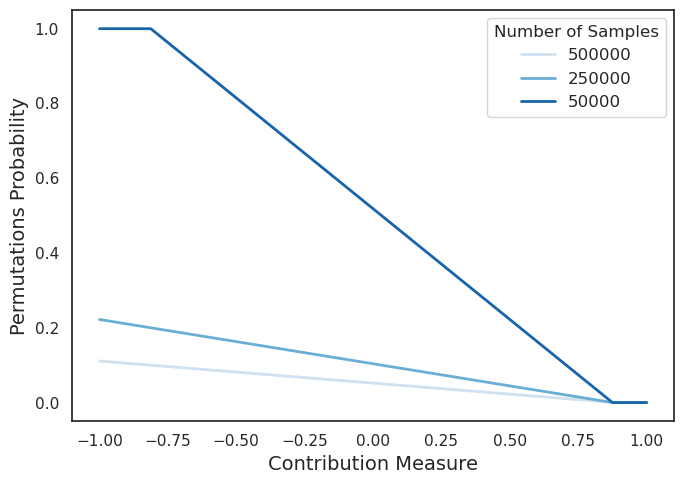

In [468]:
from matplotlib.colors import ListedColormap

contributions = np.linspace(-1, 1, 1000)
sns.set(style="white")
plt.figure(figsize=(7, 5))

colors = ListedColormap(plt.cm.Blues(np.linspace(0.2, 0.8, 3)))

for j in range(0, N, 3):

    probabilities = compute_prob_without(contributions, j)
    plt.plot(contributions, probabilities, label={0: 500000, 3: 250000, 6: 50000}[j], color=colors(j//3), linewidth=2)
 
plt.yticks(np.arange(0., 1.1, 0.2))

plt.xlabel('Contribution Measure', fontsize=14)
plt.ylabel('Permutations Probability', fontsize=14)
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Number of Samples', fontsize=12)
plt.tight_layout()

plt.savefig("img/contr_vs_prob_without.png", bbox_inches='tight')

plt.show()